# PySpark and Text Analytics: Making sense of TextRank.

The following is a [PySpark](http://spark.apache.org/) implementation for *TextRank* by Mihalcea, et al.: http://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf
This algorithm generates a *graph* from a text document, linking together related words, then runs [PageRank](http://en.wikipedia.org/wiki/PageRank) on that graph to determine the high-ranked keyphrases.
Those keyphrases summarize the text document, similar to how an human editor would summarize for an academic paper.

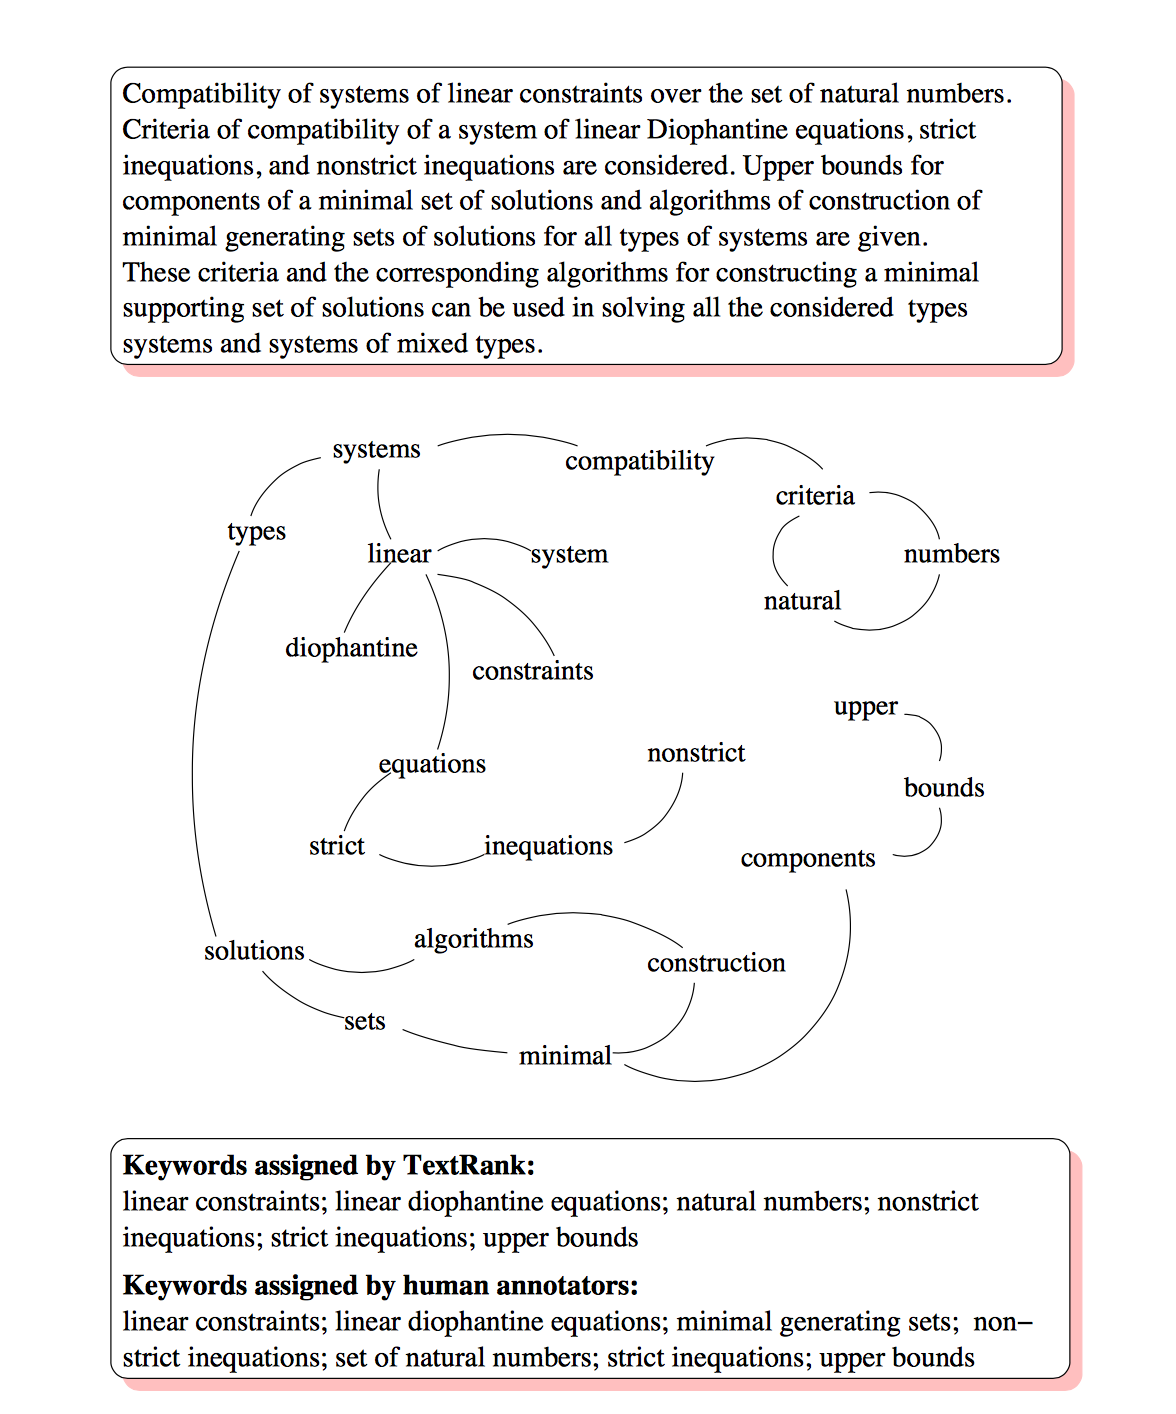

In [20]:
from IPython.display import Image
i = Image('/Users/gbreto/Downloads/spark-1.2.0/graph_paper_Rada_Mihalcea_and_Paul_Tarau.png')
i

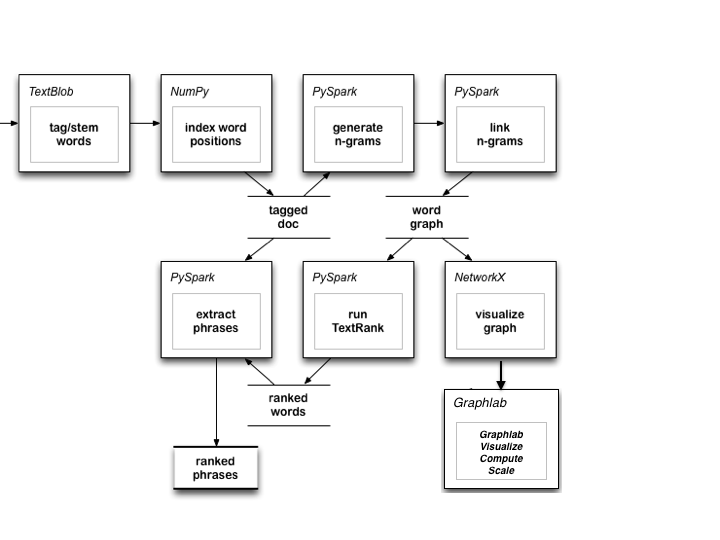

In [2]:
from IPython.display import Image
i = Image('/Users/gbreto/Downloads/spark-1.2.0/pyspark_graphlab_bt/pyspark_graphlab_bt.001.png')
i

First, we create  functions to leverage natural language processing tools: a *tokenizer* to split the text into sentences, a *tagger* to identify the part of speech for each word in a sentence, and a *stemmer* to find the root for each word:

In [1]:
import re
from operator import add
from itertools import tee, izip
import numpy as np
import nltk.data
from nltk import stem

TOKENIZER = nltk.data.load('tokenizers/punkt/english.pickle')
STEMMER = stem.porter.PorterStemmer()


def pos_tag (s):
  """high-performance part-of-speech tagger"""
  return nltk.pos_tag(s)


def wrap_words (pair):
  """wrap each (word, tag) pair as an object with fully indexed metadata"""
  global STEMMER
  index = pair[0]
  result = []
  for word, tag in pair[1]:
    word = word.lower()
    stem = STEMMER.stem(word)
    if stem == "":
      stem = word
    keep = tag in ('JJ', 'NN', 'NNS', 'NNP',)
    result.append({ "index": index, "stem": stem, "word": word, "tag": tag, "keep": keep })
    index += 1
  return result

Those functions help to annotate a text document, adding metadata to describe the role and position for each word.

Next, we define functions to generate a *graph* from the text.
The trick is to apply a sliding window across the words in each sentence, linking together the nouns and adjectives -- since these are in the noun phrases used in summaries:

In [2]:
def sliding_window (iterable, size):
  """apply a sliding window to produce 'size' tiles"""
  iters = tee(iterable, size)
  for i in xrange(1, size):
    for each in iters[i:]:
      next(each, None)
  return list(izip(*iters))


def keep_pair (pair):
  """filter the relevant linked word pairs"""
  return pair[0]["keep"] and pair[1]["keep"] and (pair[0]["word"] != pair[1]["word"])


def link_words (seq):
  """attempt to link words in a sentence"""
  return [ (seq[0], word) for word in seq[1:] ]

Given that we have a graph, we can calculate PageRank for the links in the graph, using PySpark:

In [3]:
def compute_contribs (links, rank):
  """calculate link contributions to the rank of other links"""
  num_links = len(links)
  for link in links:
    yield (link, rank / num_links,)


def text_rank_graph (neighbors, iter=20):
  """run the TextRank algorithm on the `neighbors` graph of the document"""
  links = neighbors.distinct().groupByKey().cache()
  ranks = links.map(lambda (link, neighbors): (link, 1.0))
  for iteration in xrange(iter):
    contribs = links.join(ranks).flatMap(
      lambda (link, (links, rank)): compute_contribs(links, rank))
    ranks = contribs.reduceByKey(add).mapValues(lambda rank: rank * 0.85 + 0.15)
  for (rank, key) in ranks.map(lambda x: (x[1], x[0],)).sortByKey(False).collect():
    yield key, rank

Finally, we use the ranks to extract the most important key phrases of the the text document, to create the summarization:

In [4]:
def glean_rank (pair):
  "reorder the word metdata into (K,V) pairs for sorting"
  key = pair[0]
  w = pair[1][0]
  rank = pair[1][1]
  return w["index"], (w["word"], rank,)


def extract_phrases (doc):
  """extract the top-ranked keyphrases from the given tagged doc"""
  last_index = -1000
  last_rank = 0.0
  result = []
  for index, (word, rank) in doc:
    if index - last_index > 1:
      if len(result) > 0:
        yield last_rank * len(result), ' '.join(result)
      last_rank = 0.0
      result = []
    last_rank += rank
    last_index = index
    result.append(word)

Here is the example text that is illustrated in the original *TextRank* paper: 

In [5]:
TEXT = """
The Goldman Sachs Group, Inc. is an American multinational finance company that engages in global 
investment banking, investment management, securities, and other financial services including 
asset management, mergers and acquisitions advice, prime brokerage, and securities underwriting services.
It also sponsors private equity funds, is a market maker, and is a primary dealer in the United States 
Treasury security market. Goldman Sachs also owns GS Bank USA, a direct bank.Goldman Sachs was founded 
in 1869 and is headquartered at 200 West Street in Lower Manhattan, New York City, with additional offices
in other international financial centers. Due to its involvement in securitization during the subprime 
mortgage crisis, Goldman Sachs suffered during the 2007-2008 financial crisis, and received a $10 billion 
investment from the United States Department of the Treasury as part of the Troubled Asset Relief Program, 
a financial bailout created by the Emergency Economic Stabilization Act of 2008. The investment was made in
November 2008 and was repaid in June 2009. The list of former employees of Goldman Sachs who moved on to 
government positions includes former U.S. Secretaries of the Treasury Robert Rubin and Henry Paulson; 
current United States Secretary of the Treasury Steven Mnuchin; current chief economic advisor 
Gary Cohn; European Central Bank President Mario Draghi; former Bank of Canada Governor and current 
Governor of the Bank of England Mark Carney and the current Prime Minister of Australia Malcolm Turnbull.
In addition, former Goldman employees have headed the New York Stock Exchange, the World Bank, and major 
banks such as Citigroup and Merrill Lynch."""

In [6]:
TEXT = unicode(TEXT, 'utf-8')

import string
p = "".join([" " if ch in string.punctuation and ch not in ['s'] else ch for ch in TEXT]).split()
#p.remove("s")
TEXT = " ".join(p)
TEXT = TEXT.encode('ascii','ignore')

In [7]:
sent = sc.parallelize([TEXT.split()]).map(pos_tag)
sent.collect()

[[('The', 'DT'),
  ('Goldman', 'NNP'),
  ('Sachs', 'NNP'),
  ('Group', 'NNP'),
  ('Inc', 'NNP'),
  ('is', 'VBZ'),
  ('an', 'DT'),
  ('American', 'JJ'),
  ('multinational', 'NN'),
  ('finance', 'NN'),
  ('company', 'NN'),
  ('that', 'WDT'),
  ('engages', 'VBZ'),
  ('in', 'IN'),
  ('global', 'JJ'),
  ('investment', 'NN'),
  ('banking', 'NN'),
  ('investment', 'NN'),
  ('management', 'NN'),
  ('securities', 'NNS'),
  ('and', 'CC'),
  ('other', 'JJ'),
  ('financial', 'JJ'),
  ('services', 'NNS'),
  ('including', 'VBG'),
  ('asset', 'NN'),
  ('management', 'NN'),
  ('mergers', 'NNS'),
  ('and', 'CC'),
  ('acquisitions', 'NNS'),
  ('advice', 'VBP'),
  ('prime', 'JJ'),
  ('brokerage', 'NN'),
  ('and', 'CC'),
  ('securities', 'NNS'),
  ('underwriting', 'VBG'),
  ('services', 'NNS'),
  ('It', 'PRP'),
  ('also', 'RB'),
  ('sponsors', 'VBZ'),
  ('private', 'JJ'),
  ('equity', 'NN'),
  ('funds', 'NNS'),
  ('is', 'VBZ'),
  ('a', 'DT'),
  ('market', 'NN'),
  ('maker', 'NN'),
  ('and', 'CC'),
  ('is'

In [8]:
base = list(np.cumsum(np.array(sent.map(len).collect())))
base.insert(0, 0)
base.pop()
sent_length = sc.parallelize(base)
 
tagged_doc = sent_length.zip(sent).map(wrap_words).cache()
tagged_doc.collect()

[[{'index': 0, 'keep': False, 'stem': 'the', 'tag': 'DT', 'word': 'the'},
  {'index': 1,
   'keep': True,
   'stem': 'goldman',
   'tag': 'NNP',
   'word': 'goldman'},
  {'index': 2, 'keep': True, 'stem': u'sach', 'tag': 'NNP', 'word': 'sachs'},
  {'index': 3, 'keep': True, 'stem': 'group', 'tag': 'NNP', 'word': 'group'},
  {'index': 4, 'keep': True, 'stem': 'inc', 'tag': 'NNP', 'word': 'inc'},
  {'index': 5, 'keep': False, 'stem': 'is', 'tag': 'VBZ', 'word': 'is'},
  {'index': 6, 'keep': False, 'stem': 'an', 'tag': 'DT', 'word': 'an'},
  {'index': 7,
   'keep': True,
   'stem': 'american',
   'tag': 'JJ',
   'word': 'american'},
  {'index': 8,
   'keep': True,
   'stem': u'multin',
   'tag': 'NN',
   'word': 'multinational'},
  {'index': 9,
   'keep': True,
   'stem': u'financ',
   'tag': 'NN',
   'word': 'finance'},
  {'index': 10,
   'keep': True,
   'stem': u'compani',
   'tag': 'NN',
   'word': 'company'},
  {'index': 11, 'keep': False, 'stem': 'that', 'tag': 'WDT', 'word': 'that'

![TextRank data flow](http://cdn.liber118.com/spark/ipynb/textrank/wordgraph.png)

Using the tagged document, we apply a sliding window -- based on [n-grams](http://en.wikipedia.org/wiki/N-gram) -- to construct a graph of the relevant word pairs.
Note that, unlike web pages, the graph generated here has *bidirectional* links:

The graph gets constructed from the n-grams by linking the nouns and adjectives that nearby, and linking the common stems within the text.
Consider the transformations on the initial sentence fragment:

In [9]:
tiled = tagged_doc.flatMap(lambda s: sliding_window(s, 3)).flatMap(link_words).filter(keep_pair)

t0 = tiled.map(lambda link: (link[0]["stem"], link[1]["stem"],))
t1 = tiled.map(lambda link: (link[1]["stem"], link[0]["stem"],))

neighbors = t0.union(t1)
neighbors.collect()


[('goldman', u'sach'),
 ('goldman', 'group'),
 (u'sach', 'group'),
 (u'sach', 'inc'),
 ('group', 'inc'),
 ('american', u'multin'),
 ('american', u'financ'),
 (u'multin', u'financ'),
 (u'multin', u'compani'),
 (u'financ', u'compani'),
 ('global', u'invest'),
 ('global', u'bank'),
 (u'invest', u'bank'),
 (u'bank', u'invest'),
 (u'bank', u'manag'),
 (u'invest', u'manag'),
 (u'invest', u'secur'),
 (u'manag', u'secur'),
 (u'secur', 'other'),
 ('other', u'financi'),
 ('other', u'servic'),
 (u'financi', u'servic'),
 (u'servic', 'asset'),
 ('asset', u'manag'),
 ('asset', u'merger'),
 (u'manag', u'merger'),
 (u'merger', u'acquisit'),
 (u'acquisit', 'prime'),
 ('prime', u'brokerag'),
 (u'brokerag', u'secur'),
 (u'secur', u'servic'),
 (u'privat', u'equiti'),
 (u'privat', u'fund'),
 (u'equiti', u'fund'),
 ('market', 'maker'),
 (u'primari', 'dealer'),
 (u'unit', u'treasuri'),
 (u'treasuri', u'secur'),
 (u'treasuri', 'market'),
 (u'secur', 'market'),
 (u'secur', 'goldman'),
 ('market', 'goldman'),
 

Given a graph of the full document, now let's visualize that:

Populating the interactive namespace from numpy and matplotlib


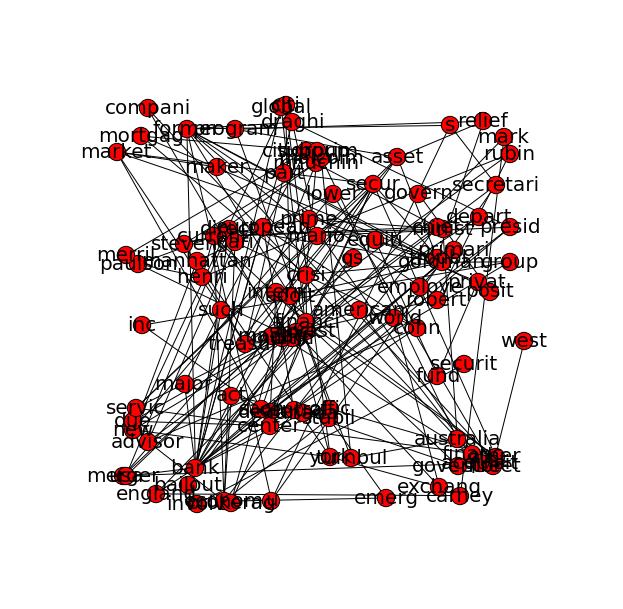

In [10]:
%pylab inline --no-import-all
#fig = figure(figsize(20,20))
plt.figure(figsize=(8,8))
import networkx as nx
 
G = nx.Graph()
 
for a, b in neighbors.collect():
  G.add_edge(a, b, weight=1.0) 
    
#labels=nx.draw_networkx_labels(G,pos=nx.spring_layout(G))
nx.draw(G, nx.random_layout(G), font_size=20, with_labels=True)

In [12]:
import graphlab as text_toolkit
text_toolkit.canvas.set_target("ipynb")
words, stems = zip(*G.edges())
edges = text_toolkit.SFrame({'words': list(words),
                   'stems': list(stems)})

verts = text_toolkit.SFrame({'name': G.nodes()})

sg = text_toolkit.SGraph()
sg = sg.add_vertices(verts, vid_field='name')
sg = sg.add_edges(edges, src_field='words', dst_field='stems')
sg = sg.add_edges(edges, src_field='stems', dst_field='words')
sgg = sg
#subgraph = sg.get_neighborhood(ids=["goldman", "sach"], radius=2,full_subgraph=True)
#sgg.show(vlabel='id', arrows=True, vlabel_hover = True, node_size = 140, highlight =['page', 'web', 'analysi'])
sg.show(vlabel='id', arrows=True, vlabel_hover = True, node_size = 140, highlight =['goldman', "sach"])

Summarization or keyphrase extraction in PySpark
=============

In [13]:

rank = sc.parallelize(text_rank_graph(neighbors)).cache()
tags = tagged_doc.flatMap(lambda x: x).map(lambda w: (w["stem"], w,))
l = tags.join(rank).map(glean_rank).sortByKey().collect()
 
for rank, phrase in sorted(set(extract_phrases(l)), reverse=True):
  print "%0.2f %s" % (rank, phrase,)

489.43 treasury steven mnuchin current chief economic advisor gary cohn european central bank president mario draghi former bank
61.50 global investment banking investment management securities
46.45 treasury security market goldman sachs
37.43 direct bank goldman sachs
33.50 subprime mortgage crisis goldman sachs
28.61 other international financial centers due
28.44 lower manhattan new york city
28.11 addition former goldman employees
22.32 henry paulson current united
21.65 goldman sachs group inc
20.66 former u s secretaries
18.59 new york stock exchange
18.54 major banks such
17.88 gs bank usa
16.00 american multinational finance company
15.65 emergency economic stabilization act
15.60 troubled asset relief program
13.48 current prime minister
13.20 other financial services
10.93 asset management mergers
10.71 treasury robert rubin
10.31 world bank
9.00 private equity funds
8.05 goldman sachs
7.74 australia malcolm turnbull
7.46 england mark carney
6.73 financial crisis
6.27 former

In [38]:
!head englishWikipedia

In [31]:

from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
conf = (SparkConf().set("spark.driver.memory", "2G").set("spark.executor.memory", "1G").set("spark.driver.extraClassPath","/Library/Python/2.7/site-packages/graphlab/graphlab-create-spark-integration.jar").set("spark.executor.instances", 2).set("spark.executor.cores", 4))
sc = SparkContext(conf=conf)

In [18]:
wikiRDD = sc.textFile('englishWikipedia')

In [7]:
from pyspark.mllib.feature import Word2Vec
inp = wikiRDD.map(lambda row: row.split(" "))
word2vec = Word2Vec()
model = word2vec.fit(inp)

In [44]:
synonyms = model.findSynonyms('china', 40)

for word, cosine_distance in synonyms:
    print "{}: {}".format(word, cosine_distance)

korea: 0.757493019104
taiwan: 0.753959655762
japan: 0.743149518967
mongolia: 0.677091300488
thailand: 0.672696352005
republic: 0.671863555908
laos: 0.649277865887
manchuria: 0.633670091629
kyrgyzstan: 0.625543296337
xinjiang: 0.625488817692
shanghai: 0.620312988758
macau: 0.620288550854
tibet: 0.618791222572
singapore: 0.616495370865
nepal: 0.614951014519
pakistan: 0.613591194153
yuan: 0.609197199345
yunnan: 0.608320534229
mainland: 0.605543136597
vietnam: 0.603313207626
malaysia: 0.602603077888
indonesia: 0.59797668457
turkey: 0.597334563732
russia: 0.595111846924
nanjing: 0.593990087509
india: 0.593221843243
guangzhou: 0.5899502635
kazakhstan: 0.587843298912
myanmar: 0.586040198803
cambodia: 0.58510440588
afghanistan: 0.584421813488
guangdong: 0.583141565323
stavropol: 0.575124919415
tajikistan: 0.574906349182
roc: 0.572554051876
uzbekistan: 0.571712553501
moldova: 0.571441054344
philippines: 0.569529891014
dnestr: 0.5686814785
taipei: 0.568345010281


Tweets from CRATE and Spark SQL 
========

COPY tweets to DIRECTORY '/tmp/tweets/' WITH (compression='gzip');

In [14]:
from pyspark import SQLContext

In [15]:
sqlContext = SQLContext(sc)

In [18]:
tweets = sqlContext.jsonFile("/tmp/tweets/")

In [19]:
tweets.printSchema()

root
 |-- created_at: long (nullable = true)
 |-- id: string (nullable = true)
 |-- retweeted: boolean (nullable = true)
 |-- source: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: long (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- followers_count: integer (nullable = true)
 |    |-- friends_count: integer (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- statuses_count: integer (nullable = true)
 |    |-- verified: boolean (nullable = true)



In [20]:
tweets.registerTempTable("tweets")

In [21]:
probowl = sqlContext.sql("SELECT * FROM tweets where text like '%probowl%'")

In [22]:
probowl.first()

Row(created_at=1422203655000, id=u'559388792209944576', retweeted=False, source=u'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', text=u"okay let's get this probowl out of the way now.", user=Row(created_at=1323896891000, description=u'it all ends here', followers_count=430, friends_count=218, id=u'437005843', location=u'az', statuses_count=44672, verified=False))

In [10]:
probowl.count()

1L